In [1]:
%matplotlib inline
import matplotlib
backend = matplotlib.get_backend()
import matplotlib.pyplot as plt

from pathlib import Path
from skimage import io
import numpy as np

import importlib
import os

# This line will supress the TF output 
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf

# midap import and reset of backend to notebook
from midap.data.tf_pipeline import TFPipe
matplotlib.use(backend)

Mac OS Version is 13.0 and patch enabled so applying the patch
Applyting Mac OS 12.3+ Alpha Channel fix.  Your default Alpha Channel is now 0.99


## Model testing with MIDAP

This notebook can be used to test models. It calculates the accuracy of the model for a test set and makes some plots. 

In [55]:
#########################
# define the parameters #
#########################


# Choose a model to test
custom_model = None # Use the standard UNet
# custom_model = "CustomUNet" # Use a model defined in ../custom_model.py

# The path were the weights should be restored from
restore_path = "../model_weights_Ecoli_GFP.h5"

# The data for the testing
image_size = (64, 64, 1)

# You can provide a list of files or a glob(star) expression with the pathlib
# E.g. this loads all images of all bacteria in the GFP channel
eval_files = list(Path("../../../midap-datasets/Divvya_gfp_unet_train/test/").glob("*raw.tif"))

In [56]:
eval_files

[PosixPath('../../../midap-datasets/Divvya_gfp_unet_train/test/pos1_gfp_frame024_raw.tif'),
 PosixPath('../../../midap-datasets/Divvya_gfp_unet_train/test/pos1_gfp_frame035_raw.tif'),
 PosixPath('../../../midap-datasets/Divvya_gfp_unet_train/test/pos1_gfp_frame013_raw.tif'),
 PosixPath('../../../midap-datasets/Divvya_gfp_unet_train/test/pos1_gfp_frame011_raw.tif'),
 PosixPath('../../../midap-datasets/Divvya_gfp_unet_train/test/pos1_gfp_frame010_raw.tif'),
 PosixPath('../../../midap-datasets/Divvya_gfp_unet_train/test/pos1_gfp_frame033_raw.tif'),
 PosixPath('../../../midap-datasets/Divvya_gfp_unet_train/test/pos1_gfp_frame041_raw.tif'),
 PosixPath('../../../midap-datasets/Divvya_gfp_unet_train/test/pos1_gfp_frame058_raw.tif'),
 PosixPath('../../../midap-datasets/Divvya_gfp_unet_train/test/pos1_gfp_frame015_raw.tif'),
 PosixPath('../../../midap-datasets/Divvya_gfp_unet_train/test/pos1_gfp_frame039_raw.tif'),
 PosixPath('../../../midap-datasets/Divvya_gfp_unet_train/test/pos1_gfp_frame030

In [57]:
# load the data 
###############

tf_pipe = TFPipe(eval_files, image_size=image_size, n_grid=2)

23-09-22 15:21:54 preprocessing.py INF   Loading file ../../../midap-datasets/Divvya_gfp_unet_train/test/pos1_gfp_frame024_raw.tif 
23-09-22 15:21:54 preprocessing.py INF   Splitting into 2x2 grid... 
23-09-22 15:21:54 preprocessing.py INF   Splitting into train and test... 
23-09-22 15:21:54 preprocessing.py INF   Loading file ../../../midap-datasets/Divvya_gfp_unet_train/test/pos1_gfp_frame035_raw.tif 
23-09-22 15:21:54 preprocessing.py INF   Splitting into 2x2 grid... 
23-09-22 15:21:54 preprocessing.py INF   Splitting into train and test... 
23-09-22 15:21:54 preprocessing.py INF   Loading file ../../../midap-datasets/Divvya_gfp_unet_train/test/pos1_gfp_frame013_raw.tif 
23-09-22 15:21:54 preprocessing.py INF   Splitting into 2x2 grid... 
23-09-22 15:21:54 preprocessing.py INF   Splitting into train and test... 
23-09-22 15:21:54 preprocessing.py INF   Loading file ../../../midap-datasets/Divvya_gfp_unet_train/test/pos1_gfp_frame011_raw.tif 
23-09-22 15:21:54 preprocessing.py INF  

In [58]:
# Load the model
################

if custom_model is None:
    # load the standard UNet
    from midap.networks.unets import UNetv1 as ModelClass
else:
    # Load the class that was defined above
    spec = importlib.util.spec_from_file_location("module", "../custom_model.py")
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    ModelClass = getattr(module, "CustomUNet")
    
# initialize the model
model = ModelClass(input_size=image_size, dropout=0.5)

# restore the weights
model.load_weights(restore_path)

In [59]:
# Test the model
evaluation = model.evaluate(x=tf_pipe.dset_test)

2/2 [==============================] - 1s 133ms/step - loss: 3.2548 - accuracy: 0.5509


1/1 [==============================] - 0s 204ms/step


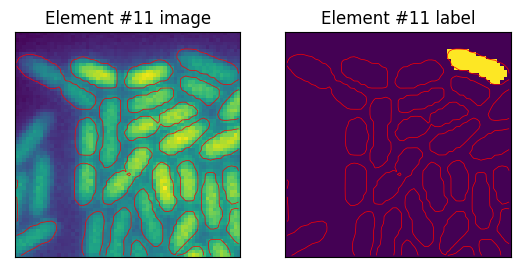

1/1 [==============================] - 0s 23ms/step


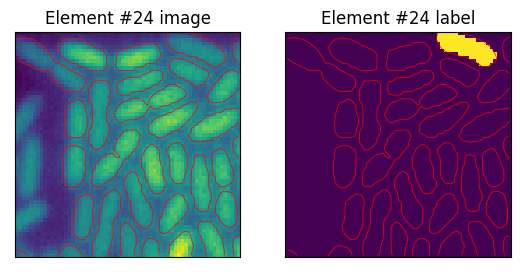

1/1 [==============================] - 0s 21ms/step


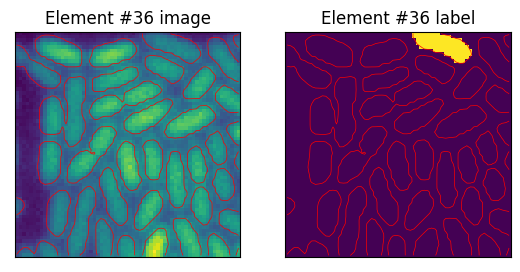

IndexError: list index out of range

In [60]:
# plot overlays
###############

# slect the indices of the test set to plot
indices_to_plot = [11, 24, 36, 113, 148]

# get the daset as list
numpy_dset = list(tf_pipe.dset_test.unbatch().as_numpy_iterator())

for index in indices_to_plot:
    # eval the model (it's index, tuple, i, w, l)
    sample = numpy_dset[index][0][0][...,0]
    w = numpy_dset[index][0][1][...,0]
    l = numpy_dset[index][0][2][...,0]
    pred = model.predict((sample[None,...,None], w[None,...,None], l[None,...,None]))[0,...,0]
    
    # create the plot
    fig, axes = plt.subplots(1,2)
    
    # overlay with original image
    axes[0].set_title(f"Element #{index} image")
    axes[0].imshow(sample)
    axes[0].contour(pred, [0.5], colors='r', linewidths=0.5)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    
    # overlay with label
    axes[1].set_title(f"Element #{index} label")
    axes[1].imshow(l)
    axes[1].contour(pred, [0.5], colors='r', linewidths=0.5)
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    plt.show()

### Eval on raw image Data

Here you can eval the network on any raw image data.

In [61]:
# define the file path you want to eval
file_path = eval_files[1]

In [62]:
# preprocessing
img = TFPipe.scale_pixel_vals(io.imread(file_path, as_gray=True))
row_shape, col_shape = img.shape

# get the new shape
div = 16
new_shape = (int(np.ceil(img.shape[0] / div) * div),
             int(np.ceil(img.shape[1] / div) * div))

# get the padded image
img_pad = np.pad(img, [[0, new_shape[0] - row_shape], [0, new_shape[1] - col_shape]], mode="reflect")

# add batch and channel dim
img_pad = img_pad[None,...,None]

In [63]:
# reload the model with new config
model = ModelClass(input_size=img_pad.shape[1:], dropout=0.5, inference=True)

# restore the weights
model.load_weights(restore_path)

In [64]:
# eval 
pred = model.predict(img_pad)

1/1 [==============================] - 0s 231ms/step


[]

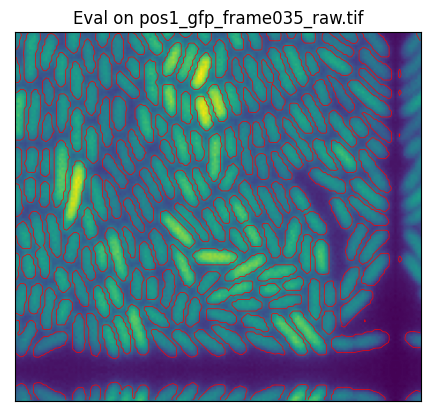

In [65]:
# create the plot
fig, axes = plt.subplots(1,1)

# overlay with original image
axes.set_title(f"Eval on {file_path.name}")
axes.imshow(img_pad[0,...,0])
axes.contour(pred[0,...,0], [0.5], colors='r', linewidths=0.5)
axes.set_xticks([])
axes.set_yticks([])

In [50]:
new_shape

(160, 176)